In [9]:
import requests
from newspaper import Article, ArticleException
from bs4 import BeautifulSoup
from dateutil.rrule import *
from datetime import *
from textblob import TextBlob
import nltk
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('punkt')


In [ ]:
# NOTE: this part of the program will take several hours to run, if you wish to skip running it,
# just grab my combined.csv file

def get_articles(dates):
    news_sites = ['foxnews.com', 'cnn.com', 'abcnews.go.com']
    data = []

    for site in news_sites:
        
        # loop through each set of dates you wish to input
        for date1, date2 in dates:
            articles = []
            
            # URL of the Google News rss
            # Consider changing the parameters at the end of this string if you search outside USA
            # https://news.google.com/rss/search?q=joe+biden+after:2020-09-30+before:2020-09-01+site:abcnews.go.com&ceid=US:en&hl=en-US&gl=US
            main_url = 'https://news.google.com/rss/search?q=joe+biden+after:" + date1 + "+before:" + 
                date2 + "+site:" + site + "&ceid=US:en&hl=en-US&gl=US'
            
            # get the results in the rss and collect the links
            response = requests.get(main_url)
            webpage = response.content
            soup = BeautifulSoup(webpage, features='xml')
            items = soup.find_all('item')
            for item in items:
                link = item.find('link').text
                articles.append(link)

            # parse the articles and get the polarity and subjectivity scores for each in your 
            # specified time frame
            for url in articles:
                # print(url)
                # We throw this in a try/except block in case we get a bad link which would kill the program
                try:
                    article = Article(url)
                    article.download()
                    article.parse()
                    article.nlp()

                    title = article.title
                    text = article.text
                                        
                    # to make sure that the article does include Joe Biden
                    # depending on your criteria, Google will often give you completely irrelevant results 
                    # in the rss
                    if 'Biden' in text:
                        # run sentiment analysis on the article text
                        # create a Textblob object and then get the sentiment values and store them
                        text_blob = TextBlob(text)
                        polarity = text_blob.polarity
                        subjectivity = text_blob.subjectivity
                        # in case we get a non-article as a link - do not include in data 
                        # (this does happen once in a while)
                        if polarity == 0 and subjectivity == 0:
                            pass
                        else:
                            # Save the necessary data to then put in a csv file, the date can be set however you please
                            save = [site, url, title, datetime.strptime(date2, '%Y-%m-%d').strftime('%Y-%m'), polarity, subjectivity] 
                            data.append(save)
                
                # If there is a bad link, move on to the next one
                except ArticleException:
                    pass

    return(data)

In [ ]:
# I use dateutil to set the timeframe - I pull articles at monthly intervals staring from 9/2020 to 8/2021
start_dates = [datetime.strftime(dt, '%Y-%m-%d') for dt in rrule(MONTHLY, dtstart=datetime(2020, 9, 1), until=datetime(2021, 8, 1))]
end_dates = [datetime.strftime(dt, '%Y-%m-%d') for dt in rrule(MONTHLY, dtstart=datetime(2020, 9, 30), bymonthday=(31, -1), bysetpos=1, until=datetime(2021, 8, 31))]
dates_list = list(zip(start_dates, end_dates))

articles = get_articles(dates_list)

In [ ]:
# write data to csv
with open('combined.csv', 'w') as csv_file:
    header = ['News Source', 'URL', 'Title', 'Month', 'Polarity', 'Subjectivity']
    writer = csv.writer(csv_file)
    writer.writerow(header)
    writer.writerows(articles)
    csv_file.close()

In [10]:
# set the dataframe, convert the date column from a string, and then sort so the data is plotted correctly
df = pd.read_csv('combined.csv')
df['Month'] = pd.to_datetime(df['Month']).dt.strftime('%Y-%m')
df.sort_values(by=['Month', 'News Source'], inplace=True)

<AxesSubplot:xlabel='Month', ylabel='Polarity'>

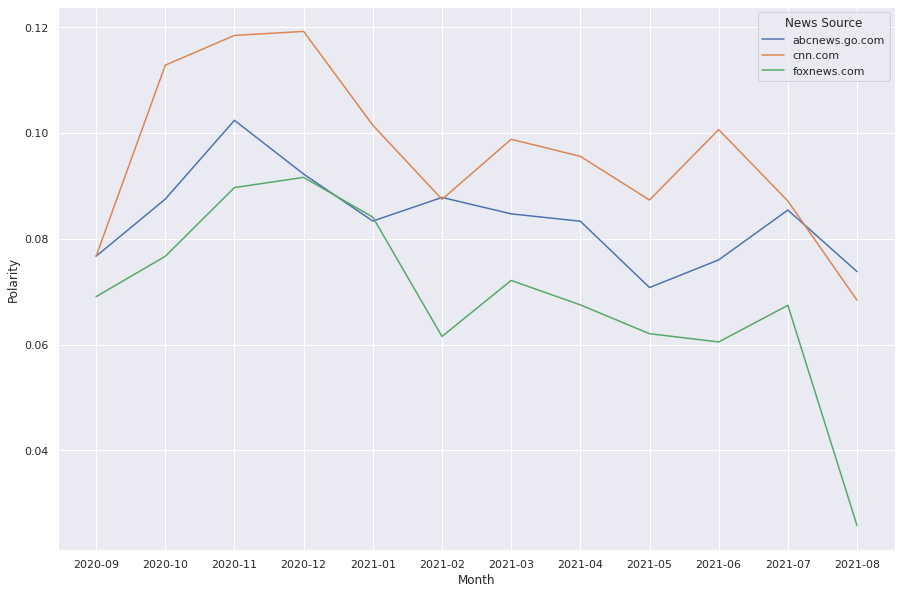

In [11]:
# line chart of the average polarity per month for each source
# I use seaborn because I found it to be the easiest for me to use
sns.set(rc = {'figure.figsize':(15,10)})
sns.lineplot(x = 'Month', y = 'Polarity', hue = 'News Source', ci = None, data = df)

<AxesSubplot:xlabel='Month', ylabel='Subjectivity'>

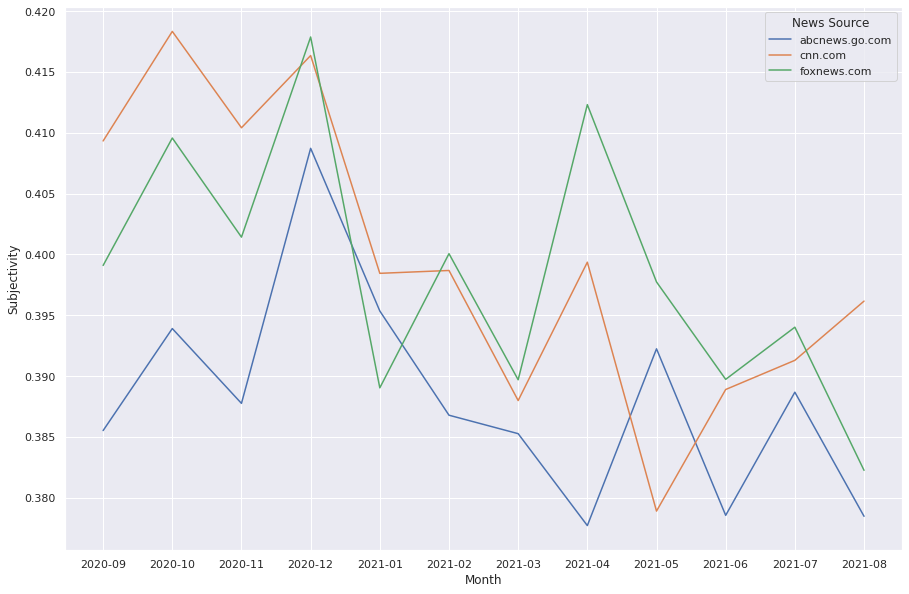

In [116]:
# line chart of the average subjectivity per month for each source
sns.lineplot(x = 'Month', y = 'Subjectivity', hue = 'News Source', ci = None, data = df)

<AxesSubplot:xlabel='Month', ylabel='Polarity'>

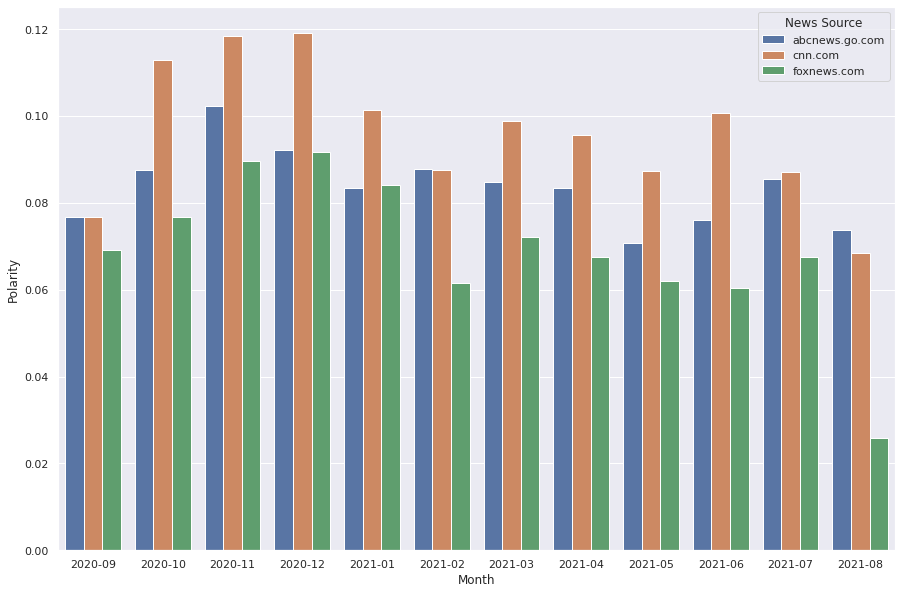

In [74]:
# bar chart of the average polarity per month for each source
sns.barplot(x = 'Month', y = 'Polarity', hue = 'News Source', ci = None, data = df)

<AxesSubplot:xlabel='Month', ylabel='Polarity'>

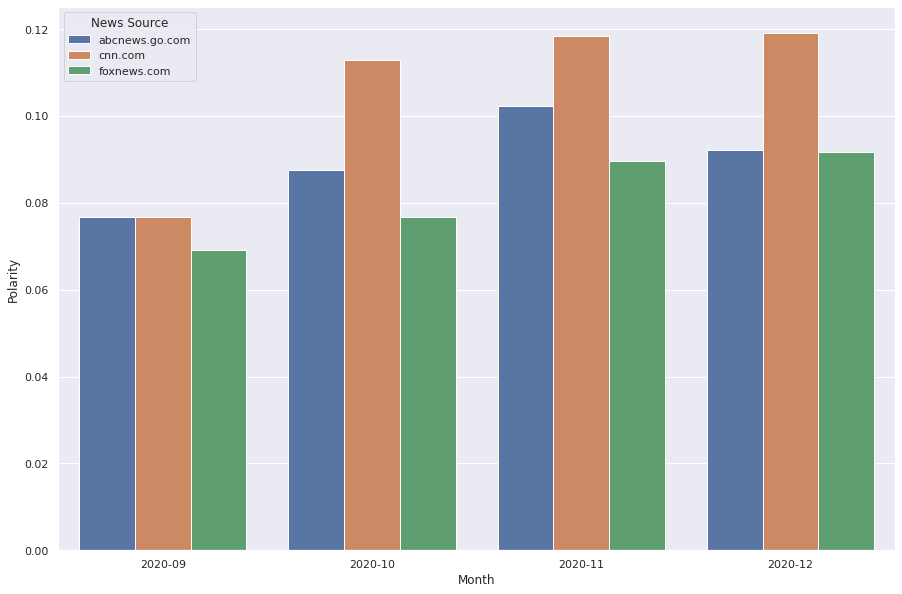

In [75]:
#in case you are interested in only data from last year
in_2020 = df[df['Month'] < '2021-01']
sns.barplot(x = 'Month', y = 'Polarity', hue = 'News Source', ci = None, data = in_2020)

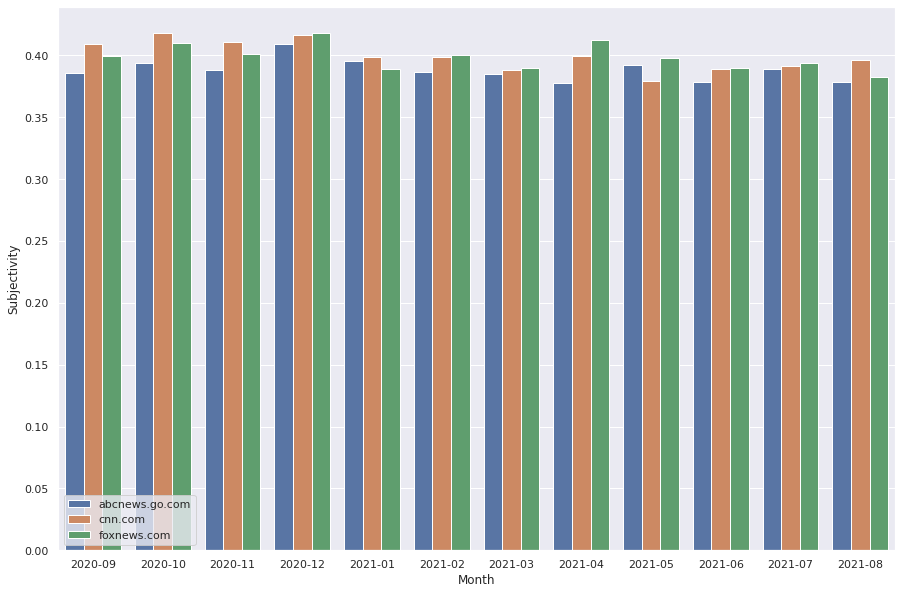

In [118]:
# bar chart of the average subjectivity per month for each source
sns.barplot(x = 'Month', y = 'Subjectivity', hue = 'News Source', ci = None, data = df)
plt.legend(loc='lower left')

<AxesSubplot:xlabel='Subjectivity', ylabel='Count'>

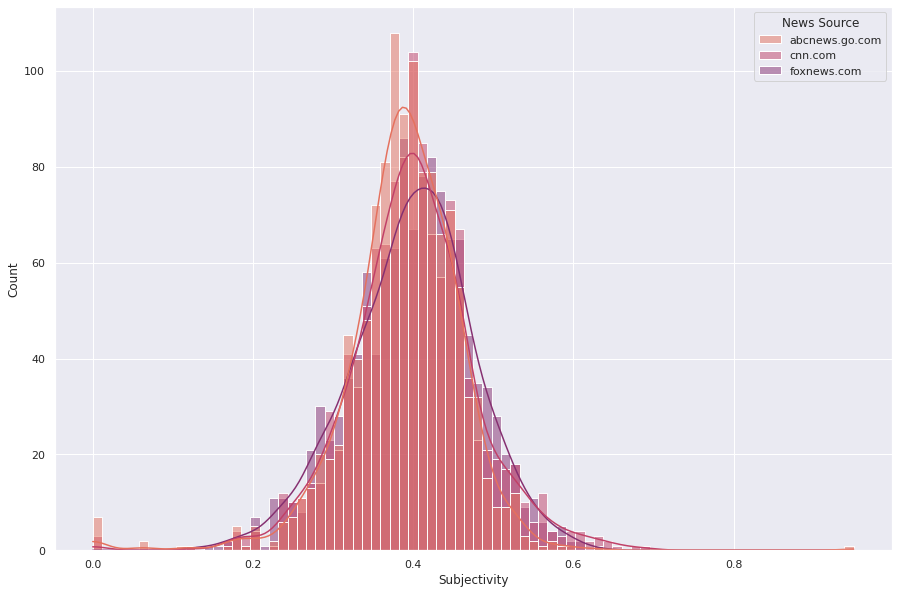

In [78]:
# histogram of all the subjectivity values from each news outlet for an entire year
sns.histplot(df, x='Subjectivity', hue='News Source', kde=True, palette='flare')

<AxesSubplot:xlabel='News Source', ylabel='Subjectivity'>

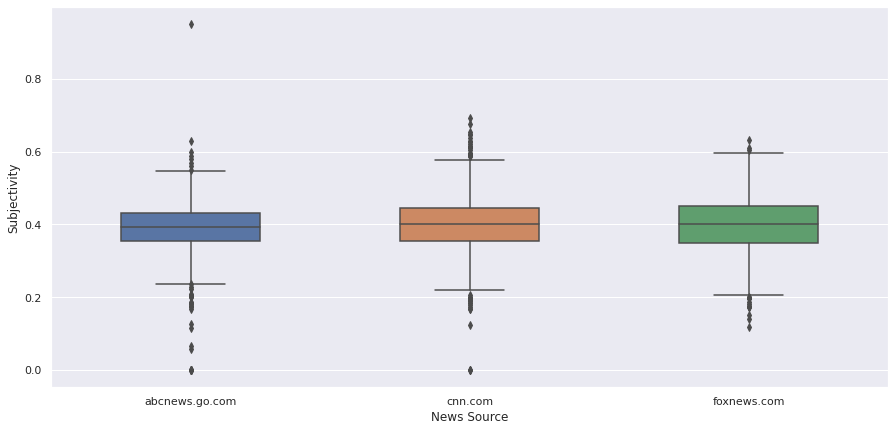

In [80]:
# box plot of all of the news sites together
sns.set(rc={'figure.figsize':(15,7)})
sns.boxplot(x = 'News Source', y = 'Subjectivity', data = df, width=.5)

<AxesSubplot:xlabel='News Source', ylabel='Polarity'>

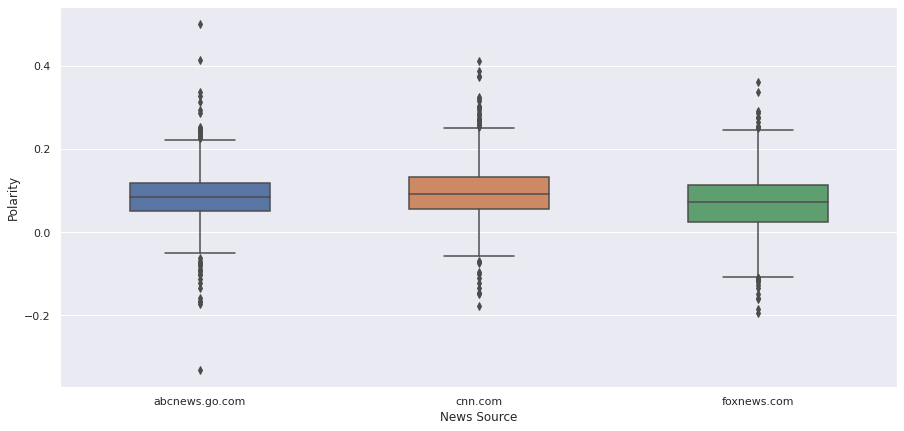

In [81]:
# box plot of all of the news sites together
sns.boxplot(x = 'News Source', y = 'Polarity', data = df, width=.5)

<AxesSubplot:xlabel='Month', ylabel='Polarity'>

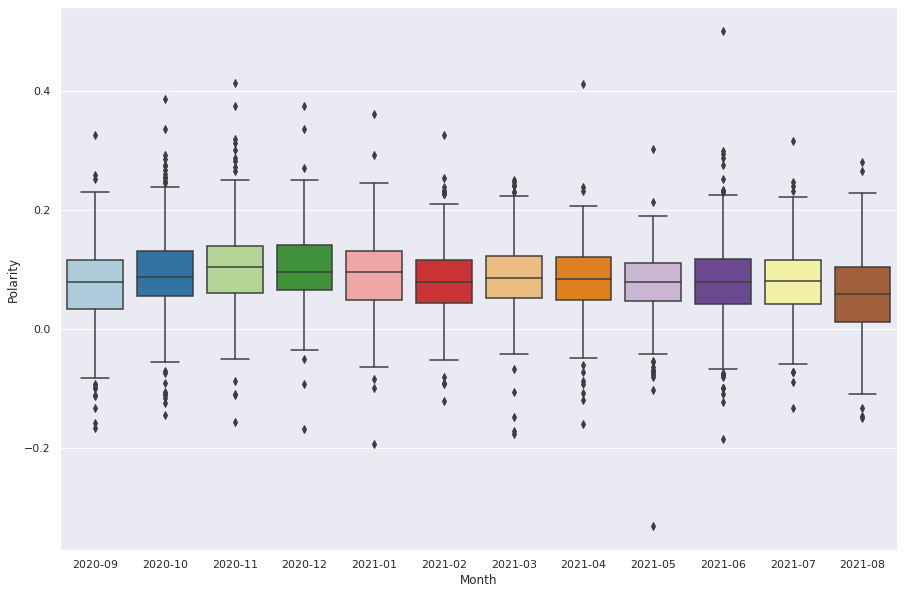

In [112]:
# box plot of all of the news sites together, records by month
sns.boxplot(x = 'Month', y = 'Polarity', data = df, palette = "Paired")

<AxesSubplot:xlabel='Month', ylabel='Polarity'>

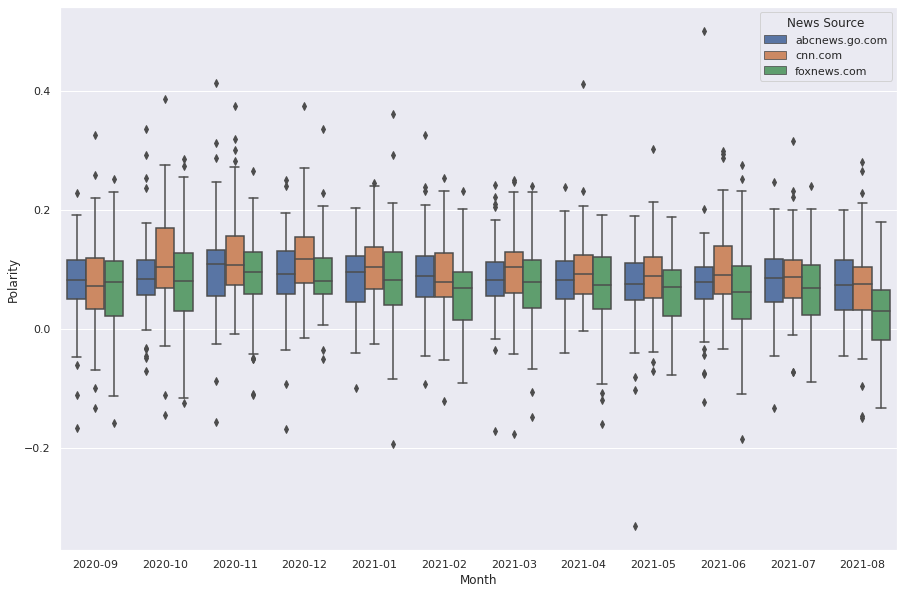

In [111]:
# Monthly box plots showing data from all news sources - polarity
sns.boxplot(x = 'Month', y = 'Polarity', hue = 'News Source', data = df)

<AxesSubplot:xlabel='Month', ylabel='Subjectivity'>

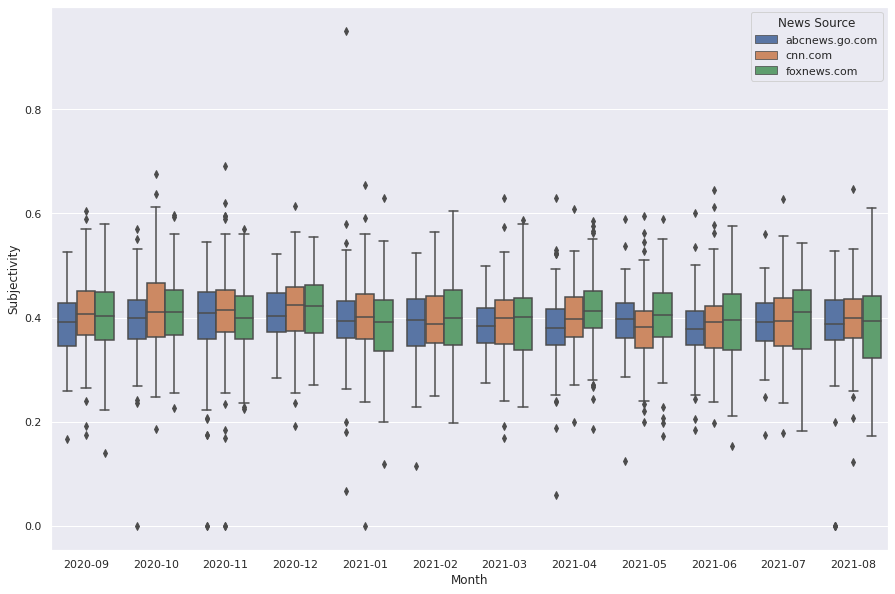

In [14]:
# Monthly box plots showing data from all news sources - subjectivity
sns.boxplot(x = 'Month', y = 'Subjectivity', hue = 'News Source', data = df)

<AxesSubplot:xlabel='Month', ylabel='Polarity'>

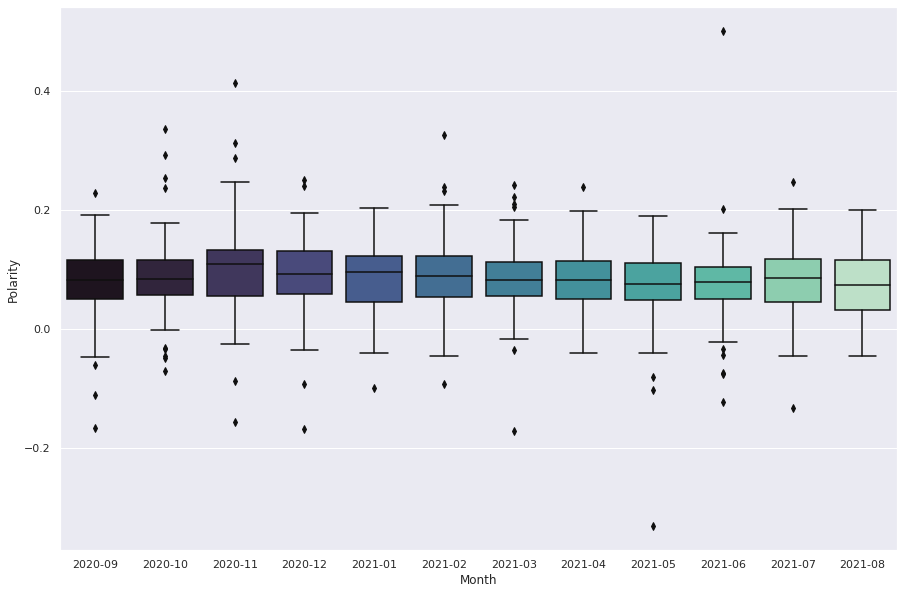

In [12]:
# ABC News monthly polarity data represented as a boxplot
abc = df.groupby(['News Source']).get_group('abcnews.go.com')
sns.boxplot(x = 'Month', y = 'Polarity', data = abc, palette = 'mako')

<AxesSubplot:xlabel='Polarity', ylabel='Count'>

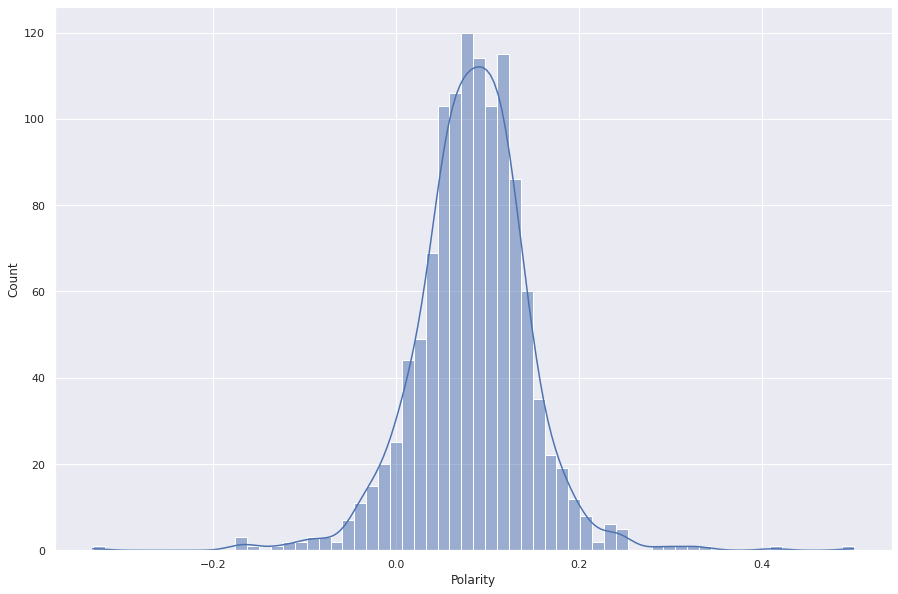

In [27]:
# histplot of the ABC polarity from all articles from the past year
sns.histplot(abc['Polarity'], kde=True)

<AxesSubplot:xlabel='Polarity', ylabel='Count'>

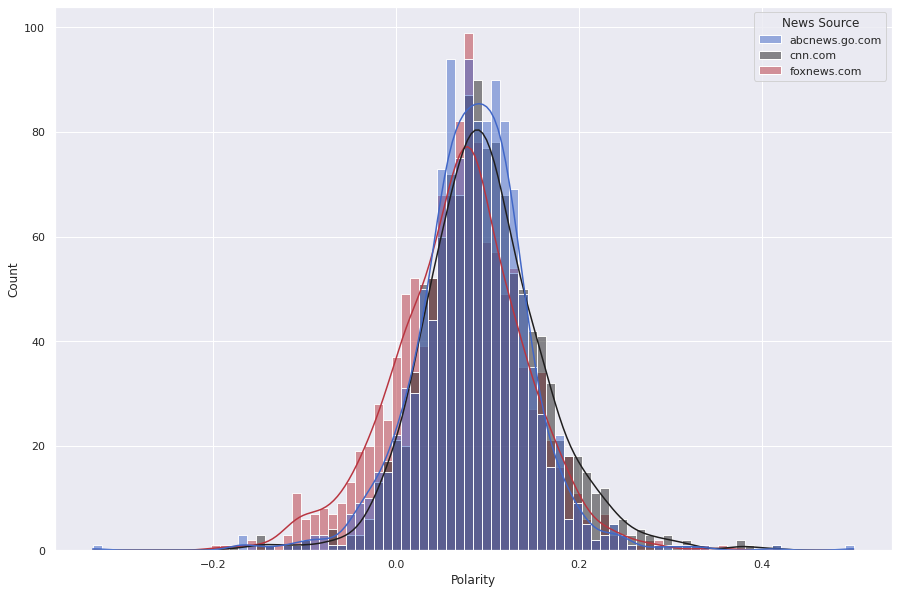

In [99]:
# We can also compare each news site
# You can plot using only one line, or you can draw a plot for each news outlet 
# separately and set your own colors

# fox = df.groupby(['News Source']).get_group('foxnews.com')
# sns.histplot(fox['Polarity'], kde=True, color='green')
# sns.histplot(abc['Polarity'], kde=True, color='blue')
# cnn = df.groupby(['News Source']).get_group('cnn.com')
# sns.histplot(cnn['Polarity'], kde=True, color='red')

sns.set(rc={'figure.figsize':(15,10)})
sns.histplot(data=df, x='Polarity', hue='News Source', kde=True, palette='icefire')

<AxesSubplot:xlabel='Polarity', ylabel='Density'>

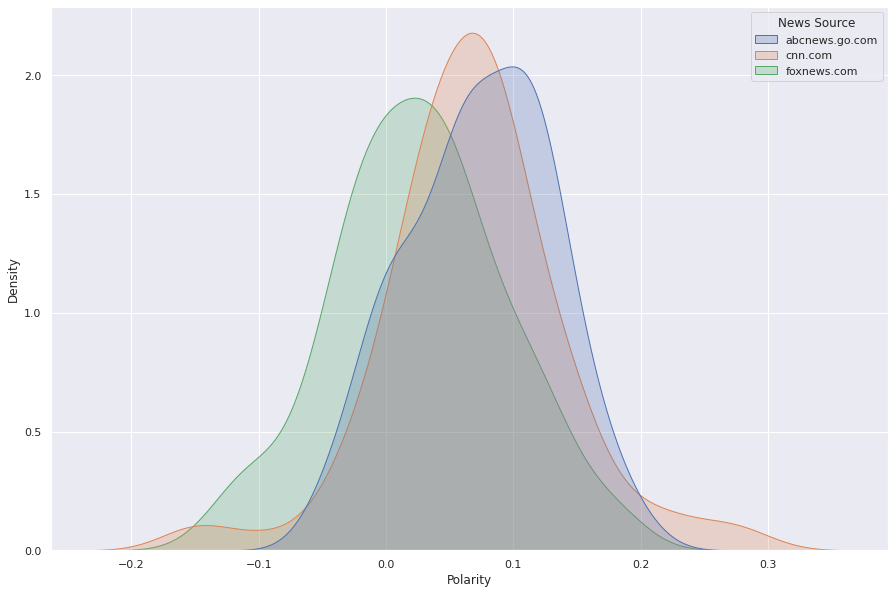

In [88]:
# for a cleaner look in this case, we can use kde plots
sns.kdeplot(data=aug, hue='News Source', x='Polarity', shade=True)

<AxesSubplot:xlabel='Polarity', ylabel='Count'>

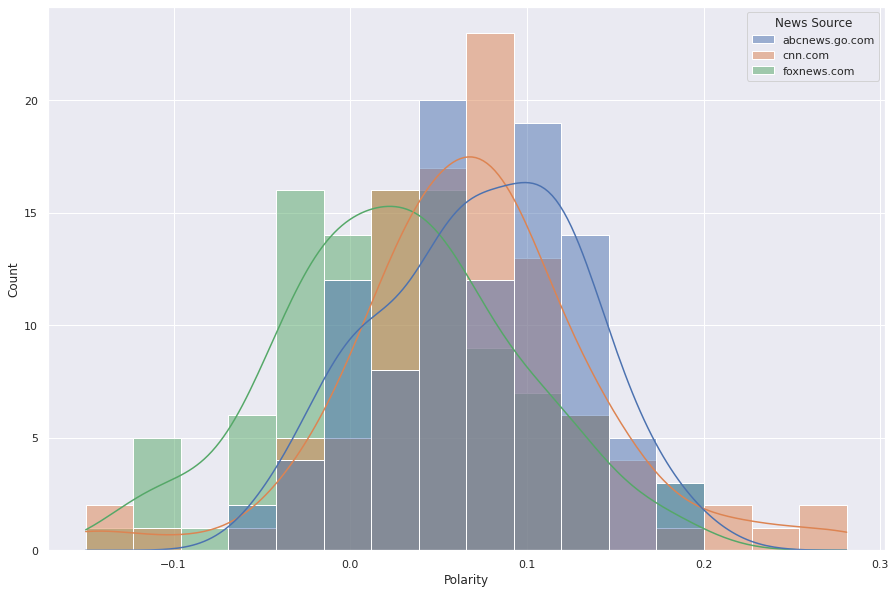

In [89]:
# If we want to analyze data from a particular month
aug = df.groupby(['Month']).get_group('2021-08')
sns.histplot(data=aug, hue='News Source', x='Polarity', kde=True)

<AxesSubplot:xlabel='Month', ylabel='Subjectivity'>

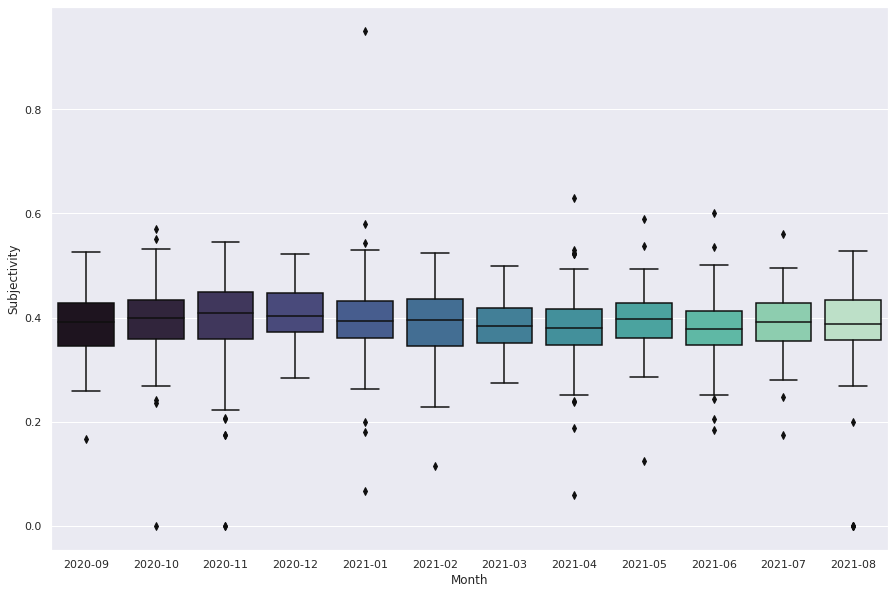

In [26]:
# ABC News monthly subjectivity data represented as a boxplot
abc = df.groupby(['News Source']).get_group('abcnews.go.com')
sns.boxplot(x = 'Month', y = 'Subjectivity', data = abc, palette = 'mako')

<AxesSubplot:xlabel='Month', ylabel='Subjectivity'>

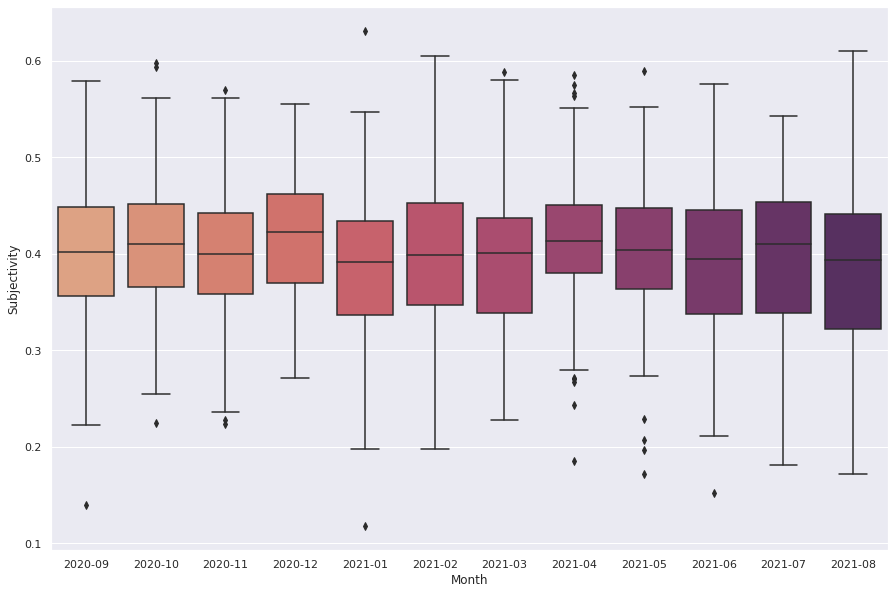

In [109]:
# same for Fox News
fox = df.groupby(['News Source']).get_group('foxnews.com')
sns.boxplot(x = 'Month', y = 'Subjectivity', data = fox, palette = 'flare')

<AxesSubplot:xlabel='Month', ylabel='Polarity'>

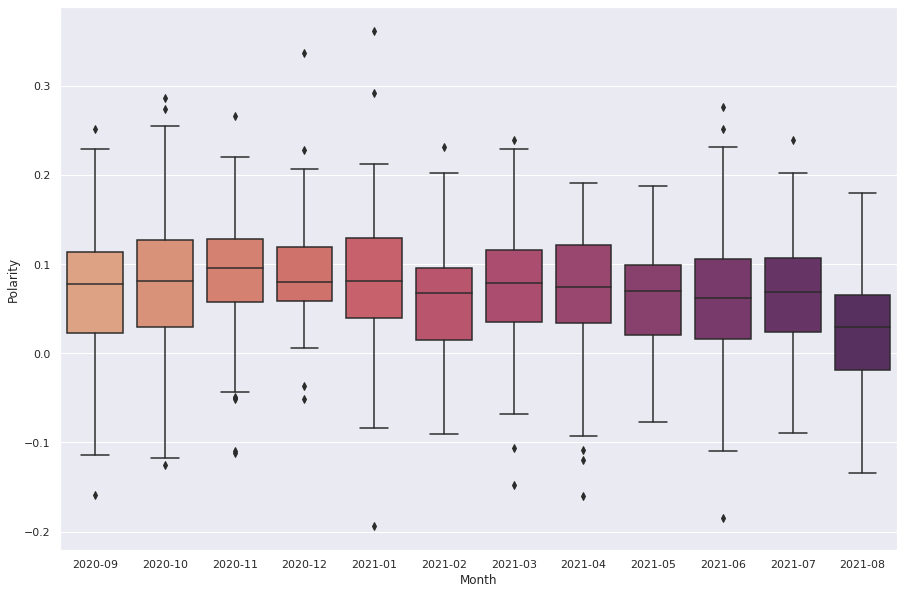

In [22]:
fox = df.groupby(['News Source']).get_group('foxnews.com')
sns.boxplot(x = 'Month', y = 'Polarity', data = fox, palette = 'flare')

<AxesSubplot:xlabel='Month', ylabel='Polarity'>

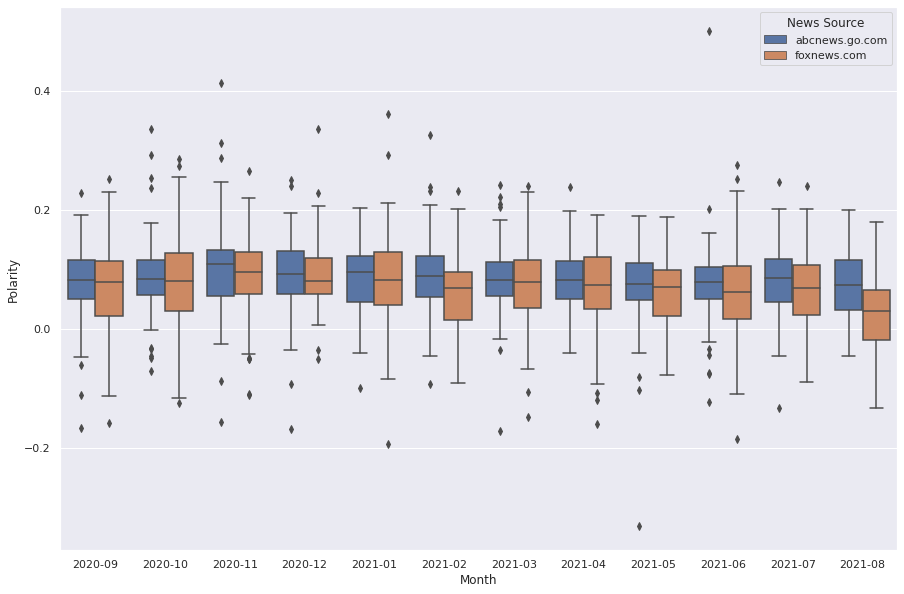

In [91]:
# compare ABC and Fox polarity data side-by-side
fox = df.groupby(['News Source']).get_group('foxnews.com')
abc = df.groupby(['News Source']).get_group('abcnews.go.com')
f_a = pd.concat([abc, fox])
sns.boxplot(x = 'Month', y = 'Polarity', hue='News Source', data = f_a)